# day 10 and 11 of #66daysofdata_NLP
## LSTM Classification model with Word2Vec


* ref: 
- [https://www.kaggle.com/guichristmann](https://www.kaggle.com/guichristmann/lstm-classification-model-with-word2vec)
* data set:
- [News of the Brazilian Newspaper](https://www.kaggle.com/marlesson/news-of-the-site-folhauol/version/1) 
- Context:
    - The dataset consists of 167.053 examples and contains Headlines, Url of Article, Complete Article and Category.


In [1]:
# Import everything that will be used
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

#from tensorflow.keras.layers.Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
df = pd.read_csv('../datasets/articles.csv')
# Clean rows with nan text and drop all columns except text and category
df = df.dropna(subset=['text']).iloc[:, [1, 3]]
with pd.option_context('max_colwidth',199):
    display(df.head(2))

,text,category
0,"Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse sa...",poder
1,"Para Oumou Sangaré, cantora e ativista malinesa, o sofrimento da mulher é universal. ""Canto com todas as minhas forças e vejo mulheres chorando ao meu redor"", disse durante um encontro na Casa da...",ilustrada


###  News to sentences

In [3]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class NewsIterator():
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for news in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            news = news.lower()
            for sentence in news.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = NewsIterator(df)
print(f"Sample tokenized sentence: \n{list(sentences)[0]}")

Sample tokenized sentence: 
['com', 'a', 'possibilidade', 'de', 'uma', 'condenação', 'impedir', 'sua', 'candidatura', 'em', '2018', 'o', 'expresidente', 'luiz', 'inácio', 'lula', 'da', 'silva', 'fez', 'nesta', 'segunda', '9', 'um', 'discurso', 'inflamado', 'contra', 'a', 'lava', 'jato', 'no', 'qual', 'disse', 'saber', 'que', 'está', 'lascado', 'exigiu', 'um', 'pedido', 'de', 'desculpas', 'do', 'juiz', 'sergio', 'moro', 'e', 'afirmou', 'que', 'mesmo', 'fora', 'da', 'disputa', 'pelo', 'planalto', 'será', 'um', 'cabo', 'eleitoral', 'expressivo', 'para', 'a', 'sucessão', 'de', 'michel', 'temer']


### Word2Vec Model

In [4]:
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=10, workers=8)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 98932 - Embedding Dim: 100


### Some validation on the quality of the Word2Vec model


In [5]:
top3_1 = w2v_model.wv.most_similar('1', topn=3)
print(f"""\n\nTop 3 most_similar words to:\n '{1}' are:\n
            {top3_1[0]}
            {top3_1[1]}
            {top3_1[2]}""")
top3_1 = w2v_model.wv.most_similar('janeiro', topn=3)
print(f"""\n\nTop 3 most_similar words to:\n '{'janeiro'}' are:\n
            {top3_1[0]}
            {top3_1[1]}
            {top3_1[2]}""")
top3_1 = w2v_model.wv.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=3)
print(f"""\n\nTop 3 most_similar words to:\n "positive=['rei', 'mulher'], negative=['homem']" are:\n
            {top3_1[0]}
            {top3_1[1]}
            {top3_1[2]}""")



Top 3 most_similar words to:
 '1' are:

            ('2', 0.9063553214073181)
            ('3', 0.8655226826667786)
            ('4', 0.81775963306427)


Top 3 most_similar words to:
 'janeiro' are:

            ('abril', 0.8160573244094849)
            ('novembro', 0.8158823847770691)
            ('fevereiro', 0.8133776783943176)


Top 3 most_similar words to:
 "positive=['rei', 'mulher'], negative=['homem']" are:

            ('rainha', 0.6744704246520996)
            ('esposa', 0.6331623792648315)
            ('coroação', 0.6183553338050842)


In [6]:
def word2token(word):
    try:
        return w2v_model.wv.key_to_index[word]
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index_to_key[token]

In [7]:
word2token('janeiro')

219

### Preparing data as sequences for LSTM

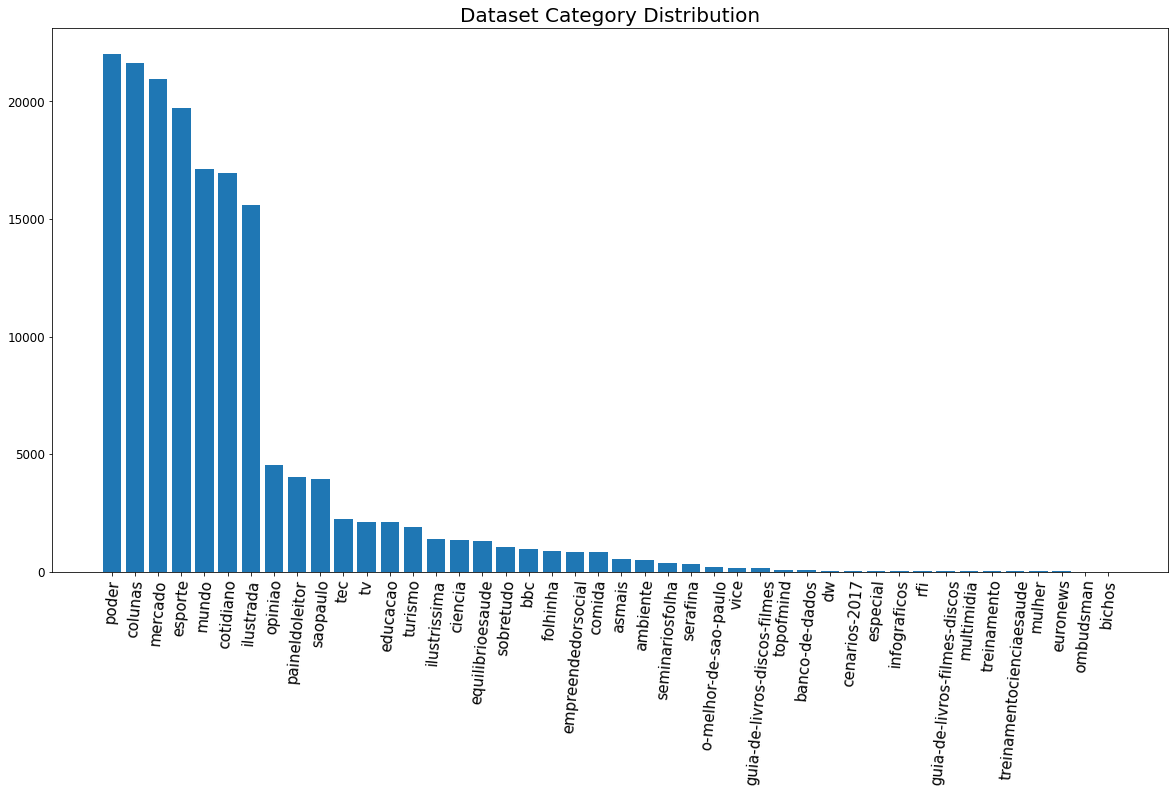

In [8]:
# First let's visualize the distribution of categories in the dataset
categories, ccount = np.unique(df.category, return_counts=True)
count_sort_ind = np.argsort(-ccount)
categories = categories[count_sort_ind]
ccount = ccount[count_sort_ind]
# Using a figsize this big seems dirty. It's the only way I figured to make
# the x labels not overlap. I suck at plotting, sorry

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)


plt.title("Dataset Category Distribution",fontsize=20)
plt.xticks(fontsize=15, rotation=85)
plt.yticks(fontsize=12)

plt.bar(categories, (ccount), align='center')

plt.show()


### Create an iterator that formats data from the dataset proper for LSTM training

In [9]:

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored
DROP_THRESHOLD = 10000

class SequenceIterator:
    def __init__(self, dataset, drop_threshold, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.category, return_counts=True)
        
        self.seq_length = seq_length
        
        # Samples of categories with less than this number of samples will be ignored
        self.drop_categos = []
        for cat, count in zip(self.categories, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(cat)
        
        # Remaining categories
        self.categories = np.setdiff1d(self.categories, self.drop_categos)
        
    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            if cat in self.drop_categos:
                continue
            
            # Make all characters lower-case
            news = news.lower()
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])            
                
            yield (words, cat)#(np.array(words), cat)

sequences = SequenceIterator(df, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

In [10]:
# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

X = []
y = []
for w, c in sequences:
    X.append(w)
    y.append(cat_dict[c])
    
# Padding sequences with 0.
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y = np.array(y)

print(X.shape)
print(y.shape)

(134055, 200)
(134055,)


In [11]:
VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

total_samples = X.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = X[random_i[:n_train],:]
train_y = y[random_i[:n_train]]
val_x = X[random_i[n_train:n_train+n_val],:]
val_y = y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)

n_categories = len(categories)

Train Shapes - X: (113947, 200) - Y: (113947,)
Val Shapes - X: (20108, 200) - Y: (20108,)


In [14]:
# Keras Embedding layer with Word2Vec weights initialization
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(embedding_size)))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5, batch_size=512, 
                    validation_data=(val_x, val_y), verbose=1)

Train on 113947 samples, validate on 20108 samples
Epoch 1/5
113947/113947 [==============================] - 79s 691us/sample - loss: 0.6778 - accuracy: 0.7654 - val_loss: 0.4669 - val_accuracy: 0.8382
Epoch 2/5
113947/113947 [==============================] - 76s 665us/sample - loss: 0.4145 - accuracy: 0.8557 - val_loss: 0.4062 - val_accuracy: 0.8585
Epoch 3/5
113947/113947 [==============================] - 82s 718us/sample - loss: 0.3571 - accuracy: 0.8751 - val_loss: 0.3871 - val_accuracy: 0.8650
Epoch 4/5
113947/113947 [==============================] - 82s 717us/sample - loss: 0.3148 - accuracy: 0.8890 - val_loss: 0.3665 - val_accuracy: 0.8732
Epoch 5/5
113947/113947 [==============================] - 81s 710us/sample - loss: 0.2828 - accuracy: 0.9003 - val_loss: 0.3590 - val_accuracy: 0.8747


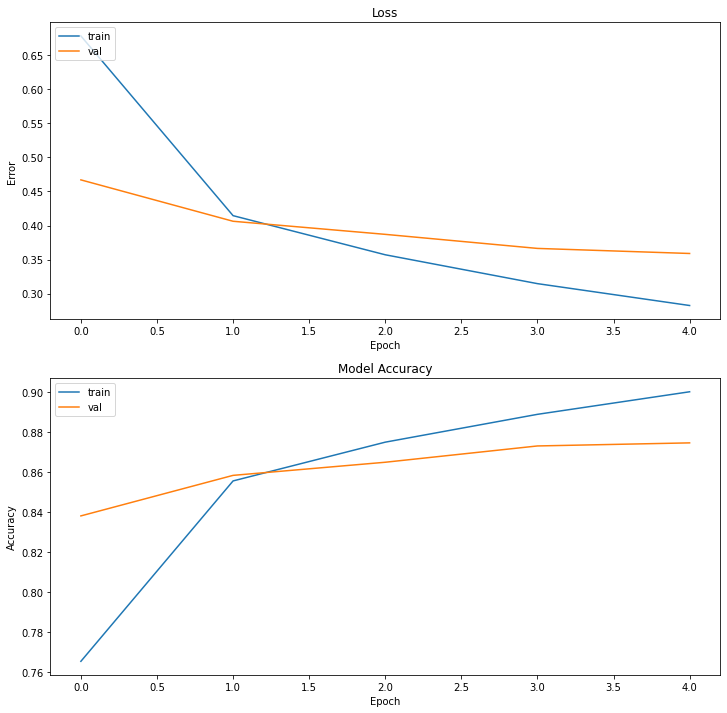

In [32]:
plt.figure(1,figsize=(12, 12))

# Plotting Loss and Accuracy Graphs
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()

plt.subplot(212)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

